In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.python.client import device_lib
def get_available_devices():
     local_device_protos = device_lib.list_local_devices()
     return [x.name for x in local_device_protos]
print(get_available_devices())

2024-04-29 21:02:59.025506: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 21:03:00.532323: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


['/device:CPU:0']


2024-04-29 21:03:03.856846: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-29 21:03:04.106859: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
filelist = []
for dirname, _, filenames in os.walk('../inputs/images/Images'):
    for filename in filenames:
        filelist.append(os.path.join(dirname, filename))
Filepaths = []
labels = []
for image_file in filelist:
    label = image_file.split(os.path.sep)[-2].split('-')[1]
    Filepaths.append(image_file)
    labels.append(label)
df = pd.DataFrame(list(zip(Filepaths, labels)), columns=['Filepath', 'Labels'])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [3]:
test_ratio = val_ratio = 0.2
train, test = train_test_split(df, test_size=test_ratio, random_state=42)
val, test = train_test_split(test, test_size=val_ratio, random_state=42)


In [4]:
img_datagen = ImageDataGenerator(rescale=1./255,
                                 rotation_range=30,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 horizontal_flip=True)


In [23]:
BATCH_SIZE = 12
VALIDATION_BATCH_SIZE = 4
train_generator = img_datagen.flow_from_dataframe(dataframe=train,
                                                  x_col="Filepath",
                                                  y_col="Labels",
                                                  batch_size=BATCH_SIZE ,
                                                  seed=42,
                                                  shuffle=True,
                                                  target_size=(299, 299))
val_generator = img_datagen.flow_from_dataframe(dataframe=val,
                                                x_col="Filepath",
                                                y_col="Labels",
                                                batch_size=VALIDATION_BATCH_SIZE  ,
                                                seed=42,
                                                shuffle=True,
                                                target_size=(299, 299))
test_generator = img_datagen.flow_from_dataframe(dataframe=test,
                                                 x_col="Filepath",
                                                 y_col="Labels",
                                                 batch_size=2 ,
                                                 seed=42,
                                                 shuffle=True,
                                                 target_size=(299, 299))

steps_per_epoch = len(train_generator )//BATCH_SIZE
validation_steps = len(val_generator)//VALIDATION_BATCH_SIZE 
print(steps_per_epoch)

Found 16464 validated image filenames belonging to 120 classes.
Found 3292 validated image filenames belonging to 120 classes.
Found 824 validated image filenames belonging to 120 classes.
114


In [24]:
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(df['Labels'].unique()), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [25]:
for layer in base_model.layers:
    layer.trainable = False

In [26]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()

In [29]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=5,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/5


/home/akiyama/.conda/envs/base310/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


114/114 ━━━━━━━━━━━━━━━━━━━━ 94s 747ms/step - accuracy: 0.2552 - loss: 4.0443 - val_accuracy: 0.6768 - val_loss: 1.3188
Epoch 2/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 92s 805ms/step - accuracy: 0.6946 - loss: 1.1317 - val_accuracy: 0.7110 - val_loss: 1.0643
Epoch 3/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 85s 744ms/step - accuracy: 0.7545 - loss: 0.9008 - val_accuracy: 0.7159 - val_loss: 0.9881
Epoch 4/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 81s 716ms/step - accuracy: 0.7432 - loss: 0.8606 - val_accuracy: 0.7098 - val_loss: 1.0612
Epoch 5/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 52s 452ms/step - accuracy: 0.7819 - loss: 0.8115 - val_accuracy: 0.7500 - val_loss: 0.5059


2024-04-29 21:33:56.476120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/akiyama/.conda/envs/base310/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


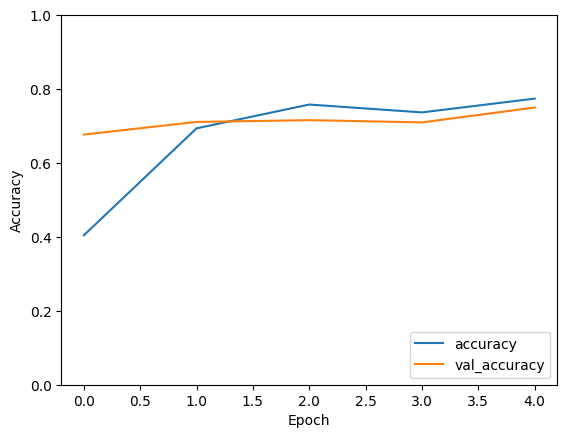

In [30]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [38]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print("Test accuracy:", test_accuracy)


412/412 ━━━━━━━━━━━━━━━━━━━━ 29s 70ms/step - accuracy: 0.7106 - loss: 0.9773
Test accuracy: 0.7220873832702637


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


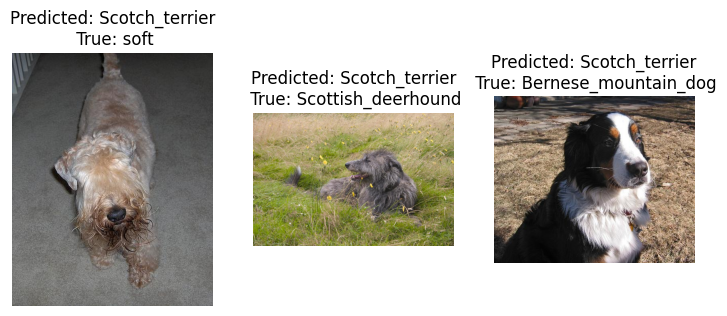

In [76]:
actual = ""
predicted_class_string =  " "
while actual != predicted_class_string:
    class_names = list(train_generator.class_indices.keys())
    sample_images = train.sample(2)['Filepath'].values

    plt.figure(figsize=(15, 10))
    for i, image_path in enumerate(sample_images):
        img = plt.imread(image_path)
        img = np.expand_dims(img, axis=0)
        prediction = model.predict(img)
        predicted_class = np.argmax(prediction)
        plt.subplot(1, 5, i+1)
        plt.imshow(plt.imread(image_path))
        actual = image_path.split("/")[-2:-1][0].split("-")[1]
        predicted_class_string=class_names[predicted_class]
        plt.title(f"Predicted: {predicted_class_string}\n True: {actual}")
        plt.axis('off')
    plt.show()